### Imports

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.compose import make_column_selector
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Vite-mon-vote project :

## ℹ About the projet :
This project aims to study the opinion of the population of Greater Nancy (France) on a few specific questions. This study is part of a student project allowing to visualize a project proposed by the city.
This study makes it possible to feed the software for the thesis with real data.

This document will help me to put the data pipeline into production for the new software. Indeed, all the parts will be reused except the data visualization part.



## ℹ About the data:

Several pieces of information are necessary to take into account to understand the data set. 

We have created a google forms to collect the votes of each person.
A QR code has been specially created so that everyone can access it quickly.

The objective was to collect people's opinions without favoring a particular social category. However, the help from the university (email bank) raises awareness among people i.e students have been more affected overall.

24 QR codes have been displayed at points of interest in Grand Nancy.

Data was retrieved in parallel from multiple locations :

*   Our school,
*   Nancy city centre,
*   Essey-lès-Nancy,
*   Saint-Max,
*   Laxou.

The survey was also shared on social networks like Facebook. However, it was difficult to recover a lot of data because our networks cannot recover thousands of data. This justifies the rather low number of votes.

**Let's visualize!**  🚀

# Data visualisation

In [344]:
data = pd.read_csv('vote.csv')
data

,time,name,gender,old,city,socio-professional-category,dependent,first,second,third
0,24/11/2021 13:11:49,Alexandre,Male,18-25,Essey-lès-Nancy,Executive,0,6,1,1
1,26/11/2021 09:55:18,Jessica,Female,18-25,Outside Grand Nancy,Students / Apprentice,0,5,3,3
2,26/11/2021 10:45:55,Thomas,Male,18-25,Nancy,Students / Apprentice,0,4,2,5
3,26/11/2021 10:47:17,Romain,Male,18-25,Nancy,Students / Apprentice,0,5,6,3
4,26/11/2021 10:48:10,Antoine,Male,18-25,Nancy,Students / Apprentice,0,4,1,2
...,...,...,...,...,...,...,...,...,...,...
487,15/12/2021 20:46:29,Tony,Male,26-40,Tomblaine,Employees,0,5,5,3
488,16/12/2021 20:16:52,None,Other,26-40,Art-sur-Meurthe,Craftsmen / Shopkeeper,0,2,2,2
489,18/12/2021 17:03:33,Kevin,Male,18-25,Nancy,Worker,0,5,6,3
490,18/12/2021 17:45:58,sandra,Female,Less than 18,Nancy,Unemployed,0,3,6,4


## Features

In [345]:
data.shape

(492, 10)

492 people answered ! 

We're getting all percentages and we add into legend.

In [346]:
percents = data['gender'].value_counts(normalize=True).tolist()
for i in range(0, len(percents), 1):
  percents[i] = percents[i]*100
percents

[50.40650406504065, 46.7479674796748, 2.8455284552845526]

In [347]:
labels = ['gender', 'old', 'city', 'socio-professional-category', 'dependent']
labels_associated = []
for l in labels:
  labels_associated.append(data[l].value_counts().index.tolist())
labels_associated

[['Male', 'Female', 'Other'],
 ['18-25', ' 41-60', '26-40', 'More than 60', 'Less than 18'],
 ['Nancy',
  'Outside Grand Nancy',
  'Vandoeuvre-les-Nancy',
  'Villers-les-Nancy',
  'Essey-lès-Nancy',
  'Laxou',
  'Saint-Max',
  'Maxéville',
  'Jarville-la-Malgrange',
  'Ludres',
  'Malzéville',
  'Tomblaine',
  'Houdemont',
  'Heillecourt',
  'Seichamps',
  'Pulnoy',
  'Saulxures-les-Nancy',
  'Laneuveville-devant-Nancy',
  'Art-sur-Meurthe',
  'Dommartemont'],
 ['Students / Apprentice',
  'Executive',
  'Employees',
  'Temp',
  'Retiree',
  'Craftsmen / Shopkeeper',
  'Self employed',
  'Unemployed',
  'Worker',
  'Farmer'],
 ['0', '2', '1', '3 et plus']]

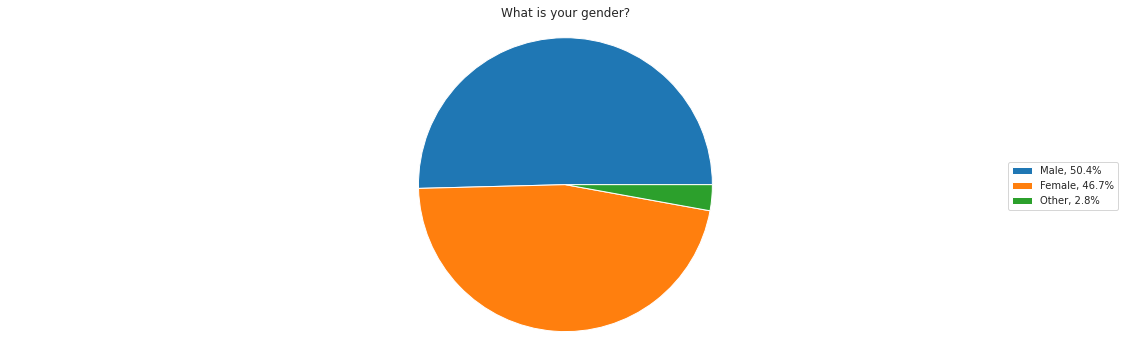

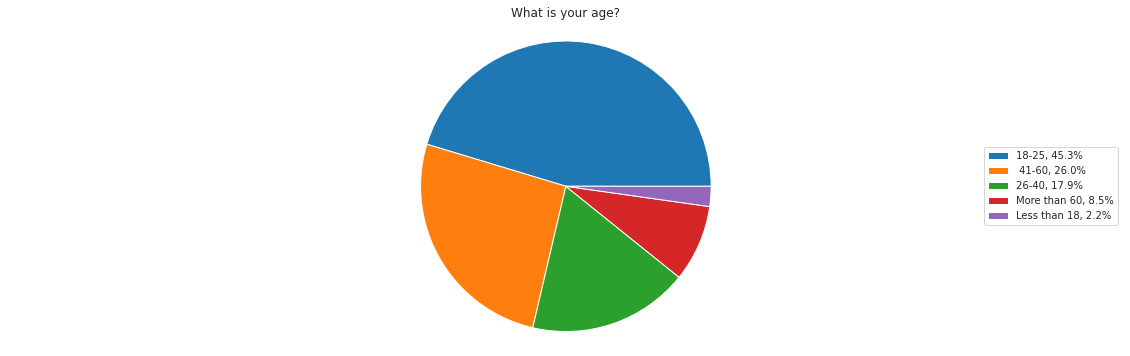

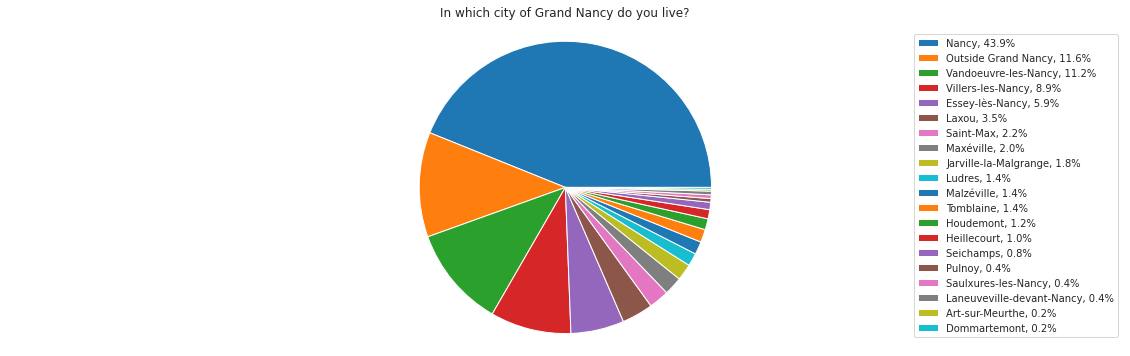

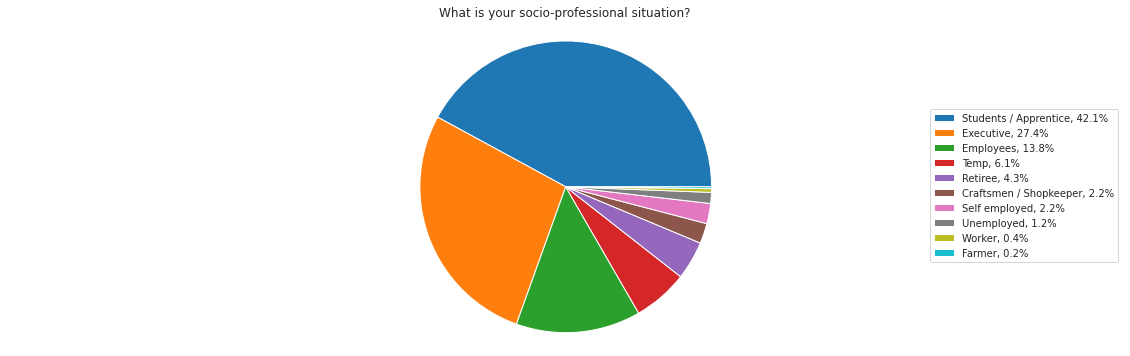

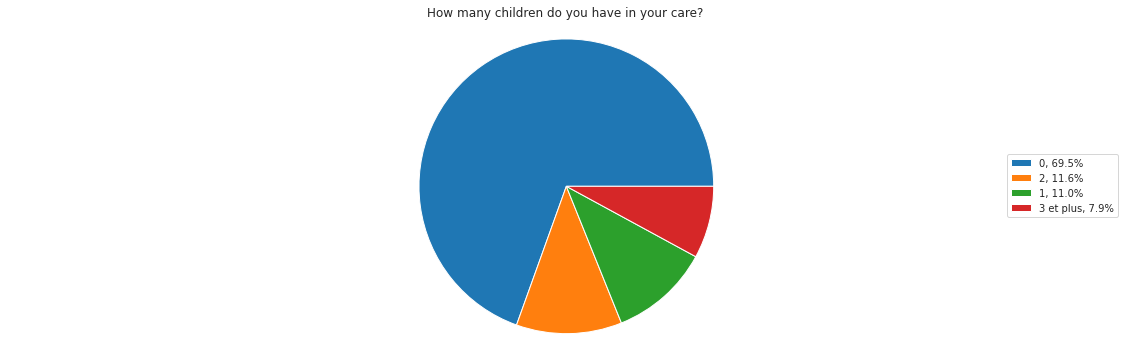

In [348]:
questions = ['What is your gender?', 'What is your age?', 'In which city of Grand Nancy do you live?', 'What is your socio-professional situation?', 'How many children do you have in your care?']
labels = ['gender', 'old', 'city', 'socio-professional-category', 'dependent']
labels_associated = []
sizes_associated = []
percents_associated = []

for l in labels:
  labels_associated.append(data[l].value_counts().index.tolist())
  sizes_associated.append(data[l].value_counts())
  percents = data[l].value_counts(normalize=True).tolist()
  for i in range(0, len(percents), 1):
    percents[i] = percents[i]*100
  percents_associated.append(percents)

for i in range(0, len(questions), 1):
  fig1, ax1 = plt.subplots(figsize=(20,6))
  ax1.pie(sizes_associated[i], shadow=False)
  ax1.axis('equal')
  plt.title(questions[i])
  plt.legend(labels=[f'{l}, {s:0.1f}%' for l, s in zip(labels_associated[i], percents_associated[i])], loc='right')
  plt.show()

## Responses

In [349]:
data['city'].value_counts()

Nancy                        216
Outside Grand Nancy           57
Vandoeuvre-les-Nancy          55
Villers-les-Nancy             44
Essey-lès-Nancy               29
Laxou                         17
Saint-Max                     11
Maxéville                     10
Jarville-la-Malgrange          9
Ludres                         7
Malzéville                     7
Tomblaine                      7
Houdemont                      6
Heillecourt                    5
Seichamps                      4
Pulnoy                         2
Saulxures-les-Nancy            2
Laneuveville-devant-Nancy      2
Art-sur-Meurthe                1
Dommartemont                   1
Name: city, dtype: int64

We calculate the color according to the proportion.

In [350]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

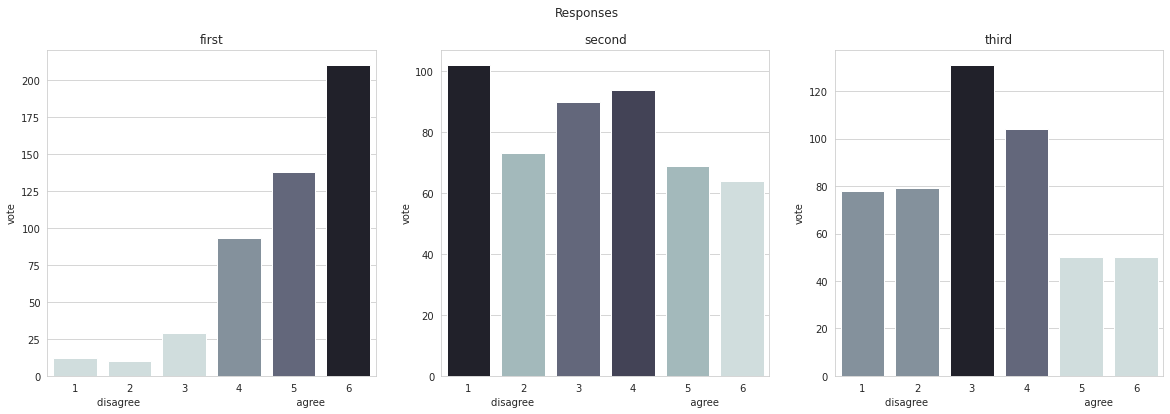

In [351]:
q = ['first', 'second', 'third']
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20,6))
fig.suptitle('Responses')
for i in range(0, 3, 1):
  axes[i].set_title(q[i])
  ordonned_array = []
  for y in range(1, 7, 1):
    ordonned_array.append(data[targets[i]].value_counts().get(y))
  axes[i].set_xlabel('disagree                                                  agree')
  axes[i].set_ylabel('vote')
  sns.barplot(ax=axes[i], x=np.arange(1, 7, 1), y=ordonned_array, palette=colors_from_values(ordonned_array, "bone_r"))

In [352]:
precisions = [{'type': ['low'], 'in': [[1,2,3],[4,5,6]], 'out': [1,2], 'max': [2]},
              {'type': ['medium'], 'in': [[1,2],[3,4],[5,6]], 'out': [1,2,3], 'max': [3]},
              {'type': ['high'], 'max': [3]}]

# Train

The main goal is to **find the best classifier** within a reasonable execution time. In addition, the **lack of data** forces us to have it classify as optimized as possible.

**Let's train!** 🧠

## Helpers for pritting logs

In [353]:
def add_sufficient_dash(text, limit):
  text = '  ' + text + '  '
  to_add = limit - len(text)
  left = to_add//2
  right = left
  while left >= 0:
    left = left - 1
    text = '-' + text
  while right >= 0:
    right = right - 1
    text = text + '-'
  return text

In [354]:
def add_sufficient_blank(text, final_word, limit):
  while limit-11-(len(text)) >= 0:
    text = text + ' '
  text = text + final_word
  return text

## Precision reduction


We reduce the precision of the answers so that the classification is less wrong. Indeed, we notice that it is often wrong with a unit. Therefore, it is advantageous to **reduce the scope of the responses**, to allow the user to obtain **more general but more precise responses**.

Three reduction methods are available:

1.   **High** : Default mode, we return the targets as they are.
2.   **Medium** : divide by 2 the reponses :
  *   [1; 2] to 1
  *   [3; 4] to 2
  *   [5; 6] to 3
3.   **Low** : divide by 3 the responses : 
  *   [1; 3] to 1
  *   [4; 6] to 2


In [355]:
def reducing_medium_precision(value):
  if value == 1 or value == 2:
    return 1
  if value == 3 or value == 4:
    return 2
  if value == 5 or value == 6:
    return 3

In [356]:
def reducing_low_precision(value):
  if value >=1 and value <= 3:
    return 1
  elif value >=4 and value <= 6:
    return 2

In [357]:
def reducing_target_precision(dataset, targets, precision):
  if precision == 'high':
    return dataset
  if precision == 'medium':
    for t in targets:
      dataset[t] = dataset[t].apply(reducing_medium_precision)
  elif precision == 'low':
    for t in targets:
      dataset[t] = dataset[t].apply(reducing_low_precision)
  else:
    return "Please use only precision='high' or precision='medium' or precision='low' downsizing."
  return dataset

In [358]:
reducing_target_precision(data, ['first', 'second', 'third'], 'medium')

,time,name,gender,old,city,socio-professional-category,dependent,first,second,third
0,24/11/2021 13:11:49,Alexandre,Male,18-25,Essey-lès-Nancy,Executive,0,3,1,1
1,26/11/2021 09:55:18,Jessica,Female,18-25,Outside Grand Nancy,Students / Apprentice,0,3,2,2
2,26/11/2021 10:45:55,Thomas,Male,18-25,Nancy,Students / Apprentice,0,2,1,3
3,26/11/2021 10:47:17,Romain,Male,18-25,Nancy,Students / Apprentice,0,3,3,2
4,26/11/2021 10:48:10,Antoine,Male,18-25,Nancy,Students / Apprentice,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...
487,15/12/2021 20:46:29,Tony,Male,26-40,Tomblaine,Employees,0,3,3,2
488,16/12/2021 20:16:52,None,Other,26-40,Art-sur-Meurthe,Craftsmen / Shopkeeper,0,1,1,1
489,18/12/2021 17:03:33,Kevin,Male,18-25,Nancy,Worker,0,3,3,2
490,18/12/2021 17:45:58,sandra,Female,Less than 18,Nancy,Unemployed,0,2,3,2


## Main function

We iterate in a loop with the following process:


1.   **Reducing** targets (optionaly).
2.   **Spliting** dataset into a training and test set.
3.   **Getting** numerical and categorical features.
4.   **Creating** numerical and categorical transformer.
5.   **Iterating** into pipeline and getting the better classifier following the better accuracy.
6.   **Returns** an array containing: 
  *   Better classifier
  *   Target
  *   Precision used
  *   DataFrame representing results


In [359]:
def train(dataset, X_data, y_data, questions, test_size, precision):
  print(add_sufficient_dash("Training model", 60))
  t = test_size
  print(add_sufficient_blank('Import parameters', '\033[92m Successfuly \033[0m', 60))
  data = reducing_target_precision(dataset, questions, precision)
  X = dataset.drop(X_data, axis=1)
  y = dataset[y_data]
  print(add_sufficient_blank('Reducing targets with precision={}'.format(precision), '\033[92m Successfuly \033[0m', 60))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t)
  print(add_sufficient_blank('Seperating train and test data with test_size={}'.format(t), '\033[92m Successfuly \033[0m', 60))
  numerical_features = make_column_selector(dtype_include=np.number)
  categorical_features = make_column_selector(dtype_exclude=np.number)
  print(add_sufficient_blank('Getting numerical and categorical features', '\033[92m Successfuly \033[0m', 60))
  numeric_transformer = Pipeline(steps=[('stdscaler', StandardScaler())])
  categorical_transformer = Pipeline(steps=[('onehotenc', OneHotEncoder(handle_unknown='ignore'))])
  print(add_sufficient_blank('Creating numerical and categorical transformer', '\033[92m Successfuly \033[0m', 60))
  col_transformer = ColumnTransformer(transformers=[('numeric_processing', numeric_transformer, numerical_features), 
                                                  ('categorical_processing', categorical_transformer, categorical_features)])
  print(add_sufficient_blank('Assembling transformers', '\033[92m Successfuly \033[0m', 60))
  estimators = [KNeighborsClassifier(), SVC(), BaggingClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]
  estimators_name = ['knn', 'svc', 'baggingclassifier', 'adaboostclassifier', 'gradientboostingclassifier']
  params = [{"knn__n_neighbors": np.arange(1, 30, 1), "knn__p": [1, 2]}, 
            {"svc__kernel": ["rbf", "linear", 'poly', 'sigmoid'], "svc__gamma": [1e-3], "svc__C": [1, 10, 100]}, 
            {"baggingclassifier__base_estimator": [KNeighborsClassifier(), SVC()], "baggingclassifier__n_estimators":[25,50,100]}, 
            {"adaboostclassifier__n_estimators":[25,50,100]},
            {"gradientboostingclassifier__n_estimators":[25,50,100]}]
  print("Params: {}".format([e for e in params]))
  array = pd.DataFrame()
  for i in range(0, len(estimators), 1):
    model = GridSearchCV(Pipeline([
                      ('transform_column', col_transformer),
                        (estimators_name[i], estimators[i])
                        ]), params[i])
    model.fit(X_train, y_train)
    print(add_sufficient_blank('Fitting {}'.format(estimators_name[i]), '\033[92m Successfuly \033[0m', 60))
    if i == 0:
      best_classifier = model
    score = model.score(X_test, y_test)
    best_score = best_classifier.score(X_test, y_test)
    array = array.append(pd.DataFrame({'name': estimators_name[i], 'score': [score]}))
    if score > best_score:
      best_classifier = model
  print(add_sufficient_dash("All models have been trained!", 60))
  return [best_classifier, y_data, precision, array]

## First

Predicting if people are **agree to make Grand Nancy much greener** (First question).

*   **to_drop**: Time, Name and First.
*   **target**: First.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: High.




In [360]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'first']
targets = ['first', 'second', 'third']
y = 'first'
first_high = train(data, to_drop, y, targets, 0.10, 'high')
first_high[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=high               Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  Fi

Fitting baggingclassifier                          Successfuly 
Fitting adaboostclassifier                         Successfuly 
Fitting gradientboostingclassifier                 Successfuly 
--------------  All models have been trained!  --------------


,name,score
0,knn,0.48
0,svc,0.40
0,baggingclassifier,0.48
0,adaboostclassifier,0.34
0,gradientboostingclassifier,0.46


Predicting if people are **agree to make Grand Nancy much greener** (First question).

*   **to_drop**: Time, Name and First.
*   **target**: First.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: Medium.




In [361]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'first']
targets = ['first', 'second', 'third']
y = 'first'
first_medium = train(data, to_drop, y, targets, 0.10, 'medium')
first_medium[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=medium             Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.68
0,svc,0.60
0,baggingclassifier,0.68
0,adaboostclassifier,0.68
0,gradientboostingclassifier,0.64


Predicting if people are **agree to make Grand Nancy much greener** (First question).

*   **to_drop**: Time, Name and First.
*   **target**: First.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: Low.


---





In [362]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'first']
targets = ['first', 'second', 'third']
y = 'first'
first_low = train(data, to_drop, y, targets, 0.10, 'low')
first_low[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=low                Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.86
0,svc,0.86
0,baggingclassifier,0.86
0,adaboostclassifier,0.84
0,gradientboostingclassifier,0.86


## Second

Predicting if people are **agree that Nancy is completely pedestrianized** (Second question).

*   **to_drop**: Time, Name and Second.
*   **target**: Second.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: High.




In [363]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'second']
targets = ['first', 'second', 'third']
y = 'second'
second_high = train(data, to_drop, y, targets, 0.10, 'high')
second_high[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=high               Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.32
0,svc,0.30
0,baggingclassifier,0.32
0,adaboostclassifier,0.28
0,gradientboostingclassifier,0.30


Predicting if people are **agree that Nancy is completely pedestrianized** (Second question).

*   **to_drop**: Time, Name and Second.
*   **target**: Second.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: Medium.




In [364]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'second']
targets = ['first', 'second', 'third']
y = 'second'
second_medium = train(data, to_drop, y, targets, 0.10, 'medium')
second_medium[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=medium             Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.64
0,svc,0.50
0,baggingclassifier,0.52
0,adaboostclassifier,0.52
0,gradientboostingclassifier,0.50


Predicting if people are **agree that Nancy is completely pedestrianized** (Second question).

*   **to_drop**: Time, Name and First.
*   **target**: First.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: Low.




In [365]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'second']
targets = ['first', 'second', 'third']
y = 'second'
second_low = train(data, to_drop, y, targets, 0.10, 'low')
second_low[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=low                Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.54
0,svc,0.60
0,baggingclassifier,0.60
0,adaboostclassifier,0.54
0,gradientboostingclassifier,0.56


## Third

Predicting if people are **agree to remove gas into house in Grand Nancy** (Third question).

*   **to_drop**: Time, Name and Third.
*   **target**: Third.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: High.




In [366]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'third']
targets = ['first', 'second', 'third']
y = 'third'
third_high = train(data, to_drop, y, targets, 0.10, 'high')
third_high[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=high               Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.42
0,svc,0.32
0,baggingclassifier,0.34
0,adaboostclassifier,0.26
0,gradientboostingclassifier,0.30


Predicting if people are **agree to remove gas into house in Grand Nancy** (Third question).

*   **to_drop**: Time, Name and Third.
*   **target**: Third.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: Medium.




In [367]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'second']
targets = ['first', 'second', 'third']
y = 'second'
third_medium = train(data, to_drop, y, targets, 0.10, 'medium')
third_medium[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=medium             Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.50
0,svc,0.50
0,baggingclassifier,0.50
0,adaboostclassifier,0.42
0,gradientboostingclassifier,0.50


Predicting if people are **agree to remove gas into house in Grand Nancy** (Third question).

*   **to_drop**: Time, Name and Third.
*   **target**: Third.
*   **all targets**: First, second and third.
*   **test_size**: 10%.
*   **precision**: Low.




In [368]:
data = pd.read_csv('vote.csv')
to_drop = ['time', 'name', 'third']
targets = ['first', 'second', 'third']
y = 'third'
third_low = train(data, to_drop, y, targets, 0.10, 'low')
third_low[3]

----------------------  Training model  ----------------------
Import parameters                                  Successfuly 
Reducing targets with precision=low                Successfuly 
Seperating train and test data with test_size=0.1  Successfuly 
Getting numerical and categorical features         Successfuly 
Creating numerical and categorical transformer     Successfuly 
Assembling transformers                            Successfuly 
Params: [{'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'knn__p': [1, 2]}, {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'svc__gamma': [0.001], 'svc__C': [1, 10, 100]}, {'baggingclassifier__base_estimator': [KNeighborsClassifier(), SVC()], 'baggingclassifier__n_estimators': [25, 50, 100]}, {'adaboostclassifier__n_estimators': [25, 50, 100]}, {'gradientboostingclassifier__n_estimators': [25, 50, 100]}]
Fitting knn                       

,name,score
0,knn,0.54
0,svc,0.56
0,baggingclassifier,0.52
0,adaboostclassifier,0.70
0,gradientboostingclassifier,0.58


# Predict

Well! We trained all classifier in order to find one target considering the others. 

**Let's predict** 🚀

## From dictionary 

We create an helper in order to predict target **easily**. We verify also all parameters and build DataFrame.

The feature **targetted must to be None**.

In [369]:
def prediction(results_from_train, gender, old, city, socio_professional_category, dependent, first, second, third):
  model = results_from_train[0]
  precision = results_from_train[2]
  features = [gender, old, city, socio_professional_category, dependent]
  questions = [first, second, third]
  none_counter = 0
  if precision == 'high':
    p = 6
  if precision == 'medium':
    p = 3
  if precision == 'low':
    p = 2
  for f in features:
    if type(f) != str:
      return 'Features must be string.'
  for q in questions:
    if type(q) != int and q != None:
      return 'Question must be integer or None.'
    if q == None:
      none_counter+=1
      if none_counter == 2:
        return 'Two much None in questions.'
    if type(q) == int and q>p:
      return 'Question has too high number than precision.'
  if none_counter == 0:
    return 'One question must be None'
  labels = ['first', 'second', 'third']
  base = {'gender': [gender], 'old': [old], 'city': [city], 'socio-professional-category': [socio_professional_category], 'dependent': [dependent]}
  for i in range(0, len(questions), 1):
    if questions[i] != None:
      base[labels[i]] = [questions[i]]
  return model.predict(pd.DataFrame(base))

**People**:

*   **Gender**: Male
*   **Old**: 18-25
*   **City**: Nancy
*   **Socio professional category**: Executive
*   **Dependent**: 0 (No child)
*   **Second**: 1 (No agree)
*   **Third**: 1 (No agree)





In [375]:
prediction(first_low, 'Male', '18-25', 'Nancy', 'Executive', '0', None, 2, 1)

array([2])

**People**:

*   **Gender**: Female
*   **Old**: 26-40
*   **City**: Laxou
*   **Socio professional category**: Employees
*   **Dependent**: 2 
*   **Second**: 3 (agree)
*   **Third**: 2 (mixed)





In [381]:
prediction(first_medium, 'Female', '26-40', 'Laxou', 'Employees', '2', None, 3, 2)

array([3])

## From csv

We adding the possibility to **predict an CSV file**, for example to predict **what people think about a question**, especially if we have a list of people in our city.

In [370]:
def prediction_from_csv(X, results):
  preds = []
  target_to_none = results[1]
  if target_to_none == 'first':
    for row in X.iterrows():
      preds.append(prediction(results, str(row[1][0]), str(row[1][1]), str(row[1][2]), str(row[1][3]), str(row[1][4]), None, row[1][5], row[1][6]))
  elif target_to_none == 'second':
    for row in X.iterrows():
      preds.append(prediction(results, str(row[1][0]), str(row[1][1]), str(row[1][2]), str(row[1][3]), str(row[1][4]), row[1][5], None, row[1][6]))
  elif target_to_none == 'third':
    for row in X.iterrows():
      preds.append(prediction(results, str(row[1][0]), str(row[1][1]), str(row[1][2]), str(row[1][3]), str(row[1][4]), row[1][5], row[1][6], None))
  else:
    return 'target_to_none is only following : "first" or "second" or "third".'
  return preds

In [374]:
data_test = pd.read_csv('vote-test.csv')
data_test = data_test.drop(['time', 'name', 'first'], axis=1)
prediction_from_csv(data_test, first_high)

[array([4]),
 array([6]),
 array([5]),
 array([6]),
 array([5]),
 array([4]),
 array([5])]